## Hands-on EESREP 3 : Flexible nuclear and CCGT plants supplying a balanced electric grid

This serie of file "Hands-on EESREP" is dedicated to the study of flexibility features in the EESREP simulation model. The primary objective is to incorporate advanced components whose flexibility is in some way restricted by physical phenomena or safety regulations.

The tutorial use_2_three_components_model.ipynb serves as the foundation for this code, which will introduce flexibility restrictions to the nuclear cluster in Hands-on EESREP 2, while the CCGT model will remain optimistic. Hence, the model uses seven main components:

-   load: fatal sink that consumes a predetermined amount of energy ;

-   cluster_Nuke: group of N1 nuclear power plants that produce energy between its minimal and maximal power when turned-on ;
-   cluster_CCGT: group of N2 Combined Cycle Gas Turbine (CCGT) that produce energy between its minimal and maximal power when turned-on ;

-   fuel_Nuke: provides the energy requested by the cluster_Nuke ;
-   fuel_CCGT: provides the energy requested by the cluster_CCGT ;

-   demand-side management: virtual production plant - that provides the system with unsupplied_energy - ensures the equilibrium between energy bid and ask. The energy is charged at a significantly higher rate compared to the rate of physical assets ;
-   spilled_energy: physical consumption plant that will consume energy on demand to ensure an equilibrium between energy bid and ask when flexibility restrictions induce a spread. The charge for consumption is intended to prevent the solver from overproducing.

A "bus" has been added to enable Kirchhoff's junction rule between the inputs and the outputs.

The model's structure can be exemplified as follows:

                                             | -->  load
              fuel_Nuke --> cluster_Nuke --> |
              fuel_CCGT --> cluster_CCGT --> |
                  demand-side management --> |
                                             | --> spilled_energy


Added in v3 :
-   jepp counter : counts the full power equivalent days of the reactor ;
-   shiftable p_min profile according to the end date of a refueling stop ;

Motivates a v4 : 
-   dependency between the p_min profile and jepp counter ;
-   simulation times should cover multiple campaigns ;

### Imports

In [1]:
import math

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from eesrep import Eesrep
from eesrep.components.generic_component import GenericComponent
from eesrep.components.converter import Cluster
from eesrep.components.sink_source import FatalSink, Source, Sink
from eesrep.eesrep_enum import TimeSerieType
from eesrep.solver_interface.generic_interface import GenericInterface

### Simulation parameters

In [2]:
global_time_step = 1                                                                        # Time step size (hours)
global_time_shift = 50                                                                      # Shift between the beginning of two sucessing horizon (time steps)
global_future_size = 100                                                                    # Duration of each horizon (time steps)
global_horizon_count = 20*0+1*95                                                                   # Number of horizons to solve (horizon)

max_load = 200.             # MWh
min_load = 0.               # MWh

global_step_count = (global_horizon_count - 1) * global_time_shift + global_future_size     # Calculates the total number of time steps
#print("Nombre de pas de simulation :", global_step_count)                                  # Prints the previous value if needed

# True activates the spilled energy virtual sink and demand-side management virtual source
global_bool_virtual_balancing = True
# 1/2/12 activates one/one/two perturbation(s) on load to be set in user-defined inputs section
global_load_perturbation = 12


### Individual nuclear power plant behaviour constraints
# True activates ramping constraints
global_NPP_bool_ramps = True
# True activates ELPO credit constraints
global_NPP_bool_creditFPPI = True
global_NPP_bool_creditFPPI_regen = False
# True activates minimum steady duration after transitions
global_NPP_bool_duration = True
# Set the date of the end of the planned stop for refueling
global_date_fin_AR = 0
# True activates the full power equivalent days monitoring
global_NPP_bool_jepp = True


### Energy mix configuration
# True instanciates nuclear individual powerplants
global_bool_Nuke_indiv = True
# True instanciates nuclear clusterized powerplants
global_bool_Nuke_cluster = False
# True instanciates CCGT clusterized powerplants
global_bool_CCGT_cluster = False
# True instanciates OCGT clusterized powerplants
global_bool_OCGT_cluster = False

# Coal and fuel to be implemented in v3

global_bool_nuke = global_bool_Nuke_cluster + global_bool_Nuke_indiv                        # Calculates if nuclear fuel has to be instanciated
global_bool_gaz = global_bool_CCGT_cluster + global_bool_OCGT_cluster                       # Calculates if gaz fuel has to be instanciated

## Model definition

### Custom components definition

In [3]:
class FlexiblePP_static(GenericComponent):
    """EESREP flexible power plant static model :
        The output evolution satisfies static constraints set through ramp_up and ramp_down"""

    def __init__(self, 
                 name:str,
                 jepp_max:float,
                 rs_duration:float,
                 efficiency:float,
                 average_lf:float,
                 p_max:float,
                 p_min_rel:float,
                 n_machine_max:float,
                 duration_on:float,
                 duration_off:float,
                 opex:float,
                 turn_on_price:float,
                 ramp_up:float,
                 ramp_down:float,
                 bool_ramps:bool,
                 creditELPOmax:float,
                 bool_creditFPPI:bool,
                 bool_creditFPPI_regen:bool,
                 bool_duration:bool,
                 date_fin_AR:float,
                 some_ts:pd.DataFrame = pd.DataFrame()):
        
        self.name = name
        self.jepp_max = jepp_max
        self.rs_duration = rs_duration
        self.efficiency = efficiency
        self.average_lf = average_lf
        self.p_max = p_max
        self.p_min_off = 0
        self.p_min_on = p_min_rel * p_max
        self.n_machine_max = n_machine_max
        self.duration_on = duration_on
        self.duration_off = duration_off
        self.opex = opex
        self.turn_on_price = turn_on_price
        self.ramp_up = ramp_up
        self.ramp_down = ramp_down
        self.bool_ramps = bool_ramps
        self.creditELPOmax = creditELPOmax
        self.bool_creditFPPI = bool_creditFPPI
        self.bool_creditFPPI_regen = bool_creditFPPI_regen
        self.bool_duration = bool_duration
        self.date_fin_AR = date_fin_AR

        #   Necessary object, instanciate empty if not used
        self.time_series = {
            # "some_time_serie":{
            #     "type":TimeSerieType.INTENSIVE,
            #     "value":some_ts
            # } 
        }

        self.boolstate = "boolstate"
        self.CS = "CS"
        self.HS = "HS"
        self.LPO = "LPO"
        self.PO = "PO"
        self.jepp = "jepp"
        self.burn_up = "burn_up"
        self.creditELPO = "creditELPO"
        self.countLPO = "coutLPO"
        self.is_step_ELPO = "is_step_ELPO"
        self.electricity = "electricity"
        self.fuel = "fuel"

        self.n_machine = "n_machine"
        self.turn_on = "turn_on"
        self.turn_off = "turn_off"
        self.turn_on_count = "turn_on_count"
        self.turn_off_count = "turn_off_count"

    def io_from_parameters(self) -> dict:
        """Lists the component Input/Output.
        """
        return {
                    "boolstate":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "CS":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "HS":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "LPO":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "PO":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "jepp":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "burn_up":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "creditELPO":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "countLPO":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "is_step_ELPO":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "electricity":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "fuel":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":False
                                },
                    "n_machine":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "turn_on":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "turn_off":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "turn_on_count":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "turn_off_count":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                }
                }
    
    def build_model(self,
        component_name:str,
        time_steps:list,
        time_series:pd.DataFrame,
        history:pd.DataFrame,
        model_interface:GenericInterface):
        """Builds the model at the current horizon.

        Parameters
        ----------
        component_name : str
            Component name to index the MILP variables
        time_steps : list
            List of the time steps length 
        time_series : pd.DataFrame
            Dataframe containing the time series values at the current horizon time steps.
        history : pd.DataFrame
            Dataframe with the variables of previous iterations if "continuity" is at true.
        model_interface : GenericInterface
            Solver interface used to provide the variables

        """

        variables = {}

        if True:
            variables["boolstate"] = model_interface.get_new_discrete_variable_list(component_name+"_boolstate_", len(time_steps), 0, 1)
            variables["CS"] = model_interface.get_new_discrete_variable_list(component_name+"_CS_", len(time_steps), 0, 1)
            variables["HS"] = model_interface.get_new_discrete_variable_list(component_name+"_HS_", len(time_steps), 0, 1)
            variables["LPO"] = model_interface.get_new_discrete_variable_list(component_name+"_LPO_", len(time_steps), 0, 1)
            variables["PO"] = model_interface.get_new_discrete_variable_list(component_name+"_PO_", len(time_steps), 0, 1)

            variables["jepp"] = model_interface.get_new_continuous_variable_list(component_name+"_jepp_", len(time_steps), 0., self.jepp_max)
            variables["burn_up"] = model_interface.get_new_continuous_variable_list(component_name+"_burnup_", len(time_steps), 0., None)
            variables["creditELPO"] = model_interface.get_new_continuous_variable_list(component_name+"_creditELPO_", len(time_steps), 0., self.creditELPOmax)
            variables["countLPO"] = model_interface.get_new_continuous_variable_list(component_name+"_countLPO_", len(time_steps), 0., None)
            variables["is_step_ELPO"] = model_interface.get_new_discrete_variable_list(component_name+"_is_step_ELPO_", len(time_steps), 0, 1)
            variables["fuel"] = model_interface.get_new_continuous_variable_list(component_name+"_fuel_", len(time_steps), 0, None)
            variables["electricity"] = model_interface.get_new_continuous_variable_list(component_name+"_electricity_", len(time_steps), self.p_min_off, self.p_max)

            variables["turn_on"] = model_interface.get_new_continuous_variable_list(component_name+"_turn_on_", len(time_steps), 0., None)
            variables["turn_off"] = model_interface.get_new_continuous_variable_list(component_name+"_turn_off_", len(time_steps), 0., None)
            variables["turn_on_count"] = model_interface.get_new_continuous_variable_list(component_name+"_turn_on_count_", len(time_steps), None, None)
            variables["turn_off_count"] = model_interface.get_new_continuous_variable_list(component_name+"_turn_off_count_", len(time_steps), None, None)

            variables["n_machine"] = model_interface.get_new_discrete_variable_list(component_name+"_n_machine_in_", len(time_steps), 0., self.n_machine_max)

            ratio_p_min_p_max = [0 for i in range(len(time_steps))]
        # end if True to collapse variable declaration

        if True:
            if len(history) == 0:
                previous_horizon_jepp = 0
            else:
                previous_horizon_jepp = history.loc[len(history)-1,"jepp"]
            
            burn_up_horizon = previous_horizon_jepp/self.jepp_max
        # end if True to collapse burn_up_horizon calculation


        ###################################################################################################
        ###################################################################################################
        ###################################################################################################
        ######################### Instantiation of constraints at each time_step ##########################
        ###################################################################################################
        ###################################################################################################
        ###################################################################################################
        for i in range(len(time_steps)):
            if True:
                # Intermediate assignement of the current step
                current_step_elec = variables["electricity"][i]
                current_step_boolstate = variables["boolstate"][i]
                current_step_jepp = variables["jepp"][i]
                current_step_creditELPO = variables["creditELPO"][i]
                current_step_countLPO = variables["countLPO"][i]
                current_step_is_step_ELPO = variables["is_step_ELPO"][i]
                current_n_machine = variables["n_machine"][i]
                current_turn_off = variables["turn_off"][i]
                current_turn_on = variables["turn_on"][i]

                # Intermediate assignement of the previous step
                if i == 0:
                    # First step of the current horizon : the previous step may not exist and might be fetched in the history
                    if len(history) == 0:
                        # First time step of the first horizon
                        previous_step_elec = 0
                        previous_step_jepp = 0
                        previous_step_creditELPO = 0
                        previous_n_machine = 0
                    else:
                        # First time step of a generic horizon
                        previous_step_elec = history.loc[len(history)-1,"electricity"]
                        previous_step_jepp = history.loc[len(history)-1,"jepp"]
                        previous_step_creditELPO = history.loc[len(history)-1,"creditELPO"]
                        previous_n_machine = history.loc[len(history)-1,"n_machine"]
                        previous_turn_off_count = history.loc[len(history)-1,"turn_off_count"]
                        previous_turn_on_count = history.loc[len(history)-1,"turn_on_count"]
                else:
                    # Generic time step of a generic horizon
                    previous_step_elec = variables["electricity"][i-1]
                    previous_step_jepp = variables["jepp"][i-1]
                    previous_step_creditELPO = variables["creditELPO"][i-1]
                    previous_n_machine = variables["n_machine"][i-1]
                    previous_turn_off_count = variables["turn_off_count"][i-1]
                    previous_turn_on_count = variables["turn_on_count"][i-1]
                # end if

                # Intermediate assignement of the boolean reflecting CS value at step i-16
                if i <= 16:
                    # First sixteen steps of the current horizon : the "16-steps-before" step may not exist and might be fetched in the history
                    if len(history) == 0:
                        # Not fetchable because not yet defined, let's assume that the first value of the first horizon fits the purpose
                        CSd_16 = variables["CS"][0]
                    else:
                        # Fetchable in the history
                        CSd_16 = history.loc[len(history)-1 + (i-16),"CS"]
                    # end if
                else:
                    # Fetchable in current horizon
                    CSd_16 = variables["CS"][i-16]
                # end if
            # end if True to collapse intermediate assignment of current_step and previous_step variables

            # Static constraint of imperfect transformation of inputs into outputs
            model_interface.add_equality(left_term = model_interface.sum_variables([
                                                                variables["electricity"][i],
                                                                -variables["fuel"][i]*self.efficiency
                                                            ]), 
                                         right_term = 0)

            # Mutual exclusivity of states
            model_interface.add_equality(left_term = model_interface.sum_variables([
                                                                variables["CS"][i],
                                                                variables["HS"][i],
                                                                variables["LPO"][i],
                                                                variables["PO"][i]
                                                            ]),
                                         right_term = 1)      

            # Synthesis of boolstate from HS, LPO and PO
            model_interface.add_equality(left_term = model_interface.sum_variables([
                                                                variables["HS"][i],
                                                                variables["LPO"][i],
                                                                variables["PO"][i]
                                                            ]),
                                         right_term = variables["boolstate"][i])
            
            ### Calculation of the evolution of the irradiation campaign in equivalent days at full power ("jepp")
            if global_NPP_bool_jepp:
                model_interface.add_equality(left_term = model_interface.sum_variables([
                                                                current_step_jepp,
                                                                -previous_step_jepp
                                                            ]), 
                                             right_term = current_step_elec/self.p_max)
            # end if global_NPP_bool_jepp
            
            ### Calculation of the approximate instantaneous burn_up to calculate the local p_min according to the real burn_up at the begining of the horizon and the average load factor
            if True:
                burn_up_approx = burn_up_horizon + (i*self.average_lf)/self.jepp_max

                # Adjusts the local jig for P_min in LPO
                if burn_up_approx <= 0.1:
                    ratio_p_min_p_max[i] = 0.92
                elif burn_up_approx <= 0.65:
                    ratio_p_min_p_max[i] = 0.2
                elif burn_up_approx <= 0.9:
                    ratio_p_min_p_max[i] = 0.2 + (burn_up_approx-0.65) * (0.86-0.2)/(0.9-0.65)
                else:
                    ratio_p_min_p_max[i] = 0.86
                # end if

                burn_up_approx_boolean = True                # Burnup calculation: approximation with average load factor (True) or with real electricity generation (False)
                if burn_up_approx_boolean:
                    # Approche théorique du burnup avec lf
                    model_interface.add_equality(left_term = variables["burn_up"][i], 
                                                    right_term = burn_up_approx)
                else:
                    # Calcul exact du burn_up
                    if i==0:
                        model_interface.add_equality(left_term = variables["burn_up"][i], 
                                                        right_term = burn_up_approx)
                    else:
                        model_interface.add_equality(left_term = model_interface.sum_variables([
                                                                    variables["burn_up"][i],
                                                                    -variables["burn_up"][i-1]
                                                                ]), 
                                                        right_term = current_step_elec/self.p_max/self.jepp_max)
                    # end if
                # end if
            # end if True to collapse burn_up calculation
            
            if True:
                # Static constraints of limited output range while running
                model_interface.add_lower_than(left_term = variables["electricity"][i], 
                                            right_term = model_interface.sum_variables([
                                                                    0 * variables["CS"][i],
                                                                    0.02 * self.p_max * variables["HS"][i],
                                                                    0.9199 * self.p_max * variables["LPO"][i],
                                                                    self.p_max * variables["PO"][i]
                                                                ])
                                                            )

                # Minimum power constraint with p_min varying at each time step
                model_interface.add_greater_than(left_term = variables["electricity"][i], 
                                                right_term = model_interface.sum_variables([
                                                                    0 * variables["CS"][i],
                                                                    0.02 * self.p_max * variables["HS"][i],
                                                                    self.p_max * ratio_p_min_p_max[i] * variables["LPO"][i],
                                                                    0.9200 * self.p_max * variables["PO"][i]
                                                                ])
                                                            )
            # end if True to collapse output level jig according to state and burnup

            if self.bool_duration:
                # Counts the number turned on and off during the past timesteps
                arr_turn_on = []
                for j in range(self.duration_on-1):
                    if i-j >= 0:
                        arr_turn_on.append(variables["turn_on"][i-j])
                    elif len(history) > 0 and len(history)+i-j >= 0:
                        arr_turn_on.append(history["turn_on"].iloc[len(history)+i-j])

                variables["turn_on_count"][i] = model_interface.sum_variables(arr_turn_on)

                arr_turn_off = []
                for j in range(self.duration_off-1):
                    if i-j >= 0:
                        arr_turn_off.append(variables["turn_off"][i-j])
                    elif len(history) > 0 and len(history)+i-j >= 0:
                        arr_turn_off.append(history["turn_off"].iloc[len(history)+i-j])

                variables["turn_off_count"][i] = model_interface.sum_variables(arr_turn_off)
            
                # Restricts the evolution of n_machine, turn_off and turn_on according to preivous timesteps
                if i == 0 and len(history) == 0:
                    # On the first step of the first horizon, turn_on and turn_off are relaxed
                    pass
                else:
                    # restricts turn off to the last n_machine running minus those forced on (turned on in the last duration_on steps)
                    model_interface.add_lower_than(left_term = current_turn_off,
                                                    right_term = model_interface.sum_variables([
                                                                    previous_n_machine,
                                                                    -previous_turn_on_count
                                                                ])
                                                            )
                    # restricts in the same way turn on
                    model_interface.add_lower_than(left_term = current_turn_on,
                                                    right_term = model_interface.sum_variables([
                                                                    self.n_machine_max,
                                                                    -previous_n_machine,
                                                                    -previous_turn_off_count
                                                                ])
                                                            )
                # end if
                    
                # Calculates current n_machine running
                model_interface.add_equality(left_term = current_n_machine, 
                                             right_term = current_step_boolstate)

                model_interface.add_equality(left_term = current_n_machine, 
                                             right_term = model_interface.sum_variables([
                                                                previous_n_machine,
                                                                -current_turn_off,
                                                                current_turn_on
                                                            ])
                                                        )
            # end if self.bool_duration
            
            if self.bool_ramps:
                # Cas premier horizon :
                    # Ramping up : CS_i-16 cannot be fetched in history. Let's assume that CS_0 is a suitable value until i > 16
                    # Ramping down : relaxed, no constraint mentionned in EDF's STE
                # Cas horizon qcq :
                    # Ramping up : CS_i-16 can be fetched in history until i > 16
                    # Ramping down : relaxed, no constraint mentionned in EDF's STE

                # A working ramping down constraint code is provided below if needed but would require minor ajustements (relaxed if boolstate is null at the current timestep)

                # Ramping up constraint, relaxed if boolstate is null at the current-16 timestep
                model_interface.add_lower_than(left_term = model_interface.sum_variables([
                                                                    current_step_elec,
                                                                    -previous_step_elec
                                                                ]),
                                                right_term = model_interface.sum_variables([
                                                                    self.ramp_up * self.p_max * CSd_16,
                                                                    1e9 * (1 - CSd_16)
                                                                ]))
                # No more ramping down constraint
                pass
                ## Ramping down constraint, relaxed if boolstate is null at the current timestep
                #model_interface.add_lower_than(left_term = model_interface.sum_variables([
                #                                                    previous_step_elec,
                #                                                    -current_step_elec
                #                                                ]),
                #                            right_term = model_interface.sum_variables([
                #                                                    self.p_max * self.ramp_down,
                #                                                    (1 - current_step_boolstate) * 1e9
                #                                                ]))
            # end if self.bool_ramps
                
            if self.bool_creditFPPI:
                # Intermediate evaluation of LPO duration on the 24 time steps before the current step
                sommeLPO = []
                for j in range(24):
                    if i-j >= 0:
                        sommeLPO.append(variables["LPO"][i-j])
                    elif len(history) > 0 and len(history)+i-j >= 0:
                        sommeLPO.append(history["LPO"].iloc[len(history)+i-j])
                    # end if
                    #print(sum(sommeLPO))  
                # end for
                
                model_interface.add_equality(left_term = current_step_countLPO,
                                                right_term = model_interface.sum_variables(sommeLPO))

                # Forces MILP solver to switch is_step_ELPO to 1 if countLPO is beyond "8 hours out of 24" threshold
                model_interface.add_lower_than(left_term = model_interface.sum_variables([
                                                current_step_countLPO,
                                                - 15e3 * current_step_is_step_ELPO
                                                ]),
                                                right_term = 8)
                
                # Evolution of credit ELPO when the current step is in ELPO
                model_interface.add_equality(left_term = model_interface.sum_variables([
                                                current_step_creditELPO,
                                                -previous_step_creditELPO
                                                ]), 
                                                right_term = current_step_is_step_ELPO)
            # end if self.bool_creditFPPI 
        # end for

        objective = model_interface.sum_variables([val * self.opex for val in variables["fuel"]]+[val for val in variables["is_step_ELPO"]])
        
        return variables, objective

### User-defined inputs

#### Load

In [4]:
perturb1_start = 250        # h
perturb1_end = 500          # h
perturb1_level = 15.        # MWh

perturb2_start = 750        # h
perturb2_end = 980          # h
perturb2_level = 0.        # MWh


if global_load_perturbation == 12 and perturb1_end <= perturb2_start:
    ### Generating a linear load ranging from min_load to max_load with two low load perturbations between user-defined clues
    fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                "value": [(min_load + i*(max_load - min_load)/global_step_count)*((i<perturb1_start) + (i>perturb1_end))*((i<perturb2_start) + (i>perturb2_end)) + perturb1_level*((i>=perturb1_start)*(i<=perturb1_end))/2 + perturb2_level*((i>=perturb2_start)*(i<=perturb2_end))/2 for i in range(global_step_count + 1)]})
elif global_load_perturbation == 1:
    ### Generating a linear load ranging from min_load to max_load with a low load perturbation between user-defined clues
    fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                "value": [(min_load + i*(max_load - min_load)/global_step_count)*((i<perturb1_start) + (i>perturb1_end)) + perturb1_level*((i>=perturb1_start)*(i<=perturb1_end))/2 for i in range(global_step_count + 1)]})
elif global_load_perturbation == 2:
    ### Generating a linear load ranging from min_load to max_load with a low load perturbation between user-defined clues
    fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                "value": [(min_load + i*(max_load - min_load)/global_step_count)*((i<perturb2_start) + (i>perturb2_end)) + perturb2_level*((i>=perturb2_start)*(i<=perturb2_end))/2 for i in range(global_step_count + 1)]})
else:
    ### Generating a linear load ranging from min_load to max_load
    fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                "value": [(min_load + i*(max_load - min_load)/global_step_count) for i in range(global_step_count + 1)]})
# end if

#### Nuclear power plant with ramping constraints

In [129]:
### NPP caracteristics (most reference values found in ITESE A-B use case)
NPP_cycle_duration_jepp = 200*24        # Duration of the irradiation campaign in full power equivalent hours
NPP_RS_duration = 30*24                 # Standard duration of the refueling stop
NPP_efficiency = 0.33                   # Fuel to electricity ratio, no cogeneration considered
NPP_average_lf = 0.81                   # Average load factor during a campaign
NPP_P_max = 100.                        # Arbitrary
NPP_P_min_rel = 0.4                     # Minimum relative output before shutdown
NPP_duration_on = 12                    # Minimum time enabled after turning on
NPP_duration_off = 16                   # Minimum time disabled after turning off
NPP_ramp_up = 0.03                      # Maximum ramping up rate after Cold Shutdown and refueling/repositioning stops
NPP_ramp_down = 0.005                   # Maximum ramping down rate
NPP_creditELPOmax = 192.                # Maximum credit ELPO consumption

### Clusterized NPP caracteristics
N1 = 10                                 # Number of NPP in the cluster

### Economic value
NPP_OPEX = 14.5                         # Cost of energy (€/MWh)
NPP_turn_on_price = 28. * NPP_P_max     # Cost of switching on (€/MW) multiplied by maximum power
NPP_FOPEX = 0.01                        # Default to disable cluster when useless (€/h)


#### CCGT cluster

In [6]:
### CCGT caracteristics (reference values found in ITESE A-B use case)
CCGT_efficiency = 0.57                      # Fuel to electricity ratio, no cogeneration considered
CCGT_P_max = 10.                            # Arbitrary
CCGT_P_min_rel = 0.4                        # Minimum relative output before shutdown
CCGT_duration_on = 2                        # Minimum time enabled after turning on
CCGT_duration_off = 2                       # Minimum time disabled after turning off

### cluster_CCGT caracteristics
N2 = 10                                     # Number of CCGTs in the cluster

### Economic value
CCGT_OPEX = 210.                            # Cost of energy (€/MWh)
CCGT_turn_on_price = 278. * CCGT_P_max      # Cost of switching on (€/MW) multiplied by maximum power
CCGT_FOPEX = 0.01                           # Default to disable cluster when useless (€/h)


#### Demand-side management : unsupplied energy

In [7]:
### equivalent virtual powerplant caracteristics (reference values found in ITESE A-B use case)
DSM_efficiency = 1.                     # Fuel to electricity ratio, no cogeneration considered
DSM_P_max = None                        # Arbitrary
DSM_P_min_rel = 0.                      # Minimum relative output before shutdown
DSM_duration_on = 6.                    # Minimum time enabled after turning on
DSM_duration_off = 1.                   # Minimum time disabled after turning off
DSM_turn_on_price = 0.                  # Cost of switching on (€/MW)

### Economic virtual value
DSM_OPEX = 500.e9                       # Cost of energy (€/MWh)
DSM_turn_on_price = 0.                  # Cost of switching on (€/MW)

#### Spilled energy

In [8]:
### equivalent virtual powerplant caracteristics (reference values found in ITESE A-B use case)
SE_efficiency = 1.                      # Fuel to electricity ratio, no cogeneration considered
SE_P_max = None                         # Arbitrary
SE_P_min_rel = 0.                       # Minimum relative output before shutdown
SE_duration_on = 1.                     # Minimum time enabled after turning on
SE_duration_off = 1.                    # Minimum time disabled after turning off
SE_turn_on_price = 0.                   # Cost of switching on (€/MW)

### Economic virtual value
SE_OPEX = 1.                            # Cost of energy (€/MWh)
SE_turn_on_price = 0.                   # Cost of switching on (€/MW)

#### Fuels

In [9]:
fuel_Nuke_price = NPP_OPEX * NPP_efficiency     # Default: back-calculation of the cost of nuclear fuel with NPP OPEX
fuel_Nuke_lb = 0.                               # Minimum consumption rate if relevant (contracts), default: 0
fuel_Nuke_ub = None                             # Maximum consumption rate if relevant (supply limits), default: None


fuel_CCGT_price = CCGT_OPEX * CCGT_efficiency   # Default: back-calculation of the cost of CCGT fuel with CCGT OPEX
fuel_CCGT_lb = 0.                               # Minimum consumption rate if relevant (contracts), default: 0
fuel_CCGT_ub = None                             # Maximum consumption rate if relevant (supply limits), default: None

fuel_DSM_price = DSM_OPEX * DSM_efficiency      # Default: back-calculation of the cost of DSM fuel with DSM OPEX
fuel_DSM_lb = 0.                                # Minimum consumption rate
fuel_DSM_ub = None                              # Maximum consumption rate

###   Model and components instantiation

The following blocks generates the EESREP object and each component.

In [10]:
model = Eesrep(interface="docplex")
model.define_time_range(time_step = global_time_step, 
                        time_shift = global_time_shift, 
                        future_size = global_future_size, 
                        horizon_count = global_horizon_count)

### Load
load = FatalSink(name="load", 
                    sink_flow = fs_df)
model.add_component(load)


#### Fuel source components

In [11]:
if global_bool_nuke:
    fuel_Nuke = Source(name="fuel_Nuke",
                    p_max = fuel_Nuke_ub,
                    p_min = fuel_Nuke_lb,
                    price = fuel_Nuke_price)
    model.add_component(fuel_Nuke)
# end if

if global_bool_gaz:
    fuel_CCGT = Source(name="fuel_CCGT",
                    p_max = fuel_CCGT_ub,
                    p_min = fuel_CCGT_lb,
                    price = fuel_CCGT_price)
    model.add_component(fuel_CCGT)
# end if


#### Individual flexible power plant components

In [12]:
if global_bool_Nuke_indiv:
    flexible_static_Nuke = FlexiblePP_static(name="flexible_static_Nuke",
                                            jepp_max = NPP_cycle_duration_jepp,
                                            rs_duration = NPP_RS_duration,
                                            efficiency = NPP_efficiency,
                                            average_lf = NPP_average_lf,
                                            p_max = NPP_P_max,
                                            p_min_rel = NPP_P_min_rel,
                                            n_machine_max=1,
                                            duration_on = NPP_duration_on,
                                            duration_off = NPP_duration_off,
                                            opex = NPP_OPEX,
                                            turn_on_price = NPP_turn_on_price,
                                            ramp_up = NPP_ramp_up,
                                            ramp_down = NPP_ramp_down,
                                            bool_ramps = global_NPP_bool_ramps,
                                            creditELPOmax = NPP_creditELPOmax,
                                            bool_creditFPPI = global_NPP_bool_creditFPPI,
                                            bool_creditFPPI_regen = global_NPP_bool_creditFPPI_regen,
                                            bool_duration = global_NPP_bool_duration,
                                            date_fin_AR = global_date_fin_AR)
    model.add_component(flexible_static_Nuke)
# end if

#### Clusterized power plants components

In [13]:
if global_bool_Nuke_cluster:
    cluster_Nuke = Cluster(name="cluster_Nuke",
                                    efficiency = NPP_efficiency,
                                    p_max = NPP_P_max,
                                    p_min = NPP_P_min_rel * NPP_P_max,
                                    n_machine_max = N1,
                                    duration_on = NPP_duration_on,
                                    duration_off = NPP_duration_off,
                                    turn_on_price = NPP_turn_on_price)
    model.add_component(cluster_Nuke)
# end if

if global_bool_CCGT_cluster:
    cluster_CCGT = Cluster(name="cluster_CCGT",
                                    efficiency = CCGT_efficiency,
                                    p_max = CCGT_P_max,
                                    p_min = CCGT_P_min_rel * CCGT_P_max,
                                    n_machine_max = N2,
                                    duration_on = CCGT_duration_on,
                                    duration_off = CCGT_duration_off,
                                    turn_on_price = CCGT_turn_on_price)
    model.add_component(cluster_CCGT)
# end if

#### Virtual balancing components : spilled energy and demand-side management

In [14]:
if global_bool_virtual_balancing:
    DSM = Source(name="Demand_side_Management",
                p_max = fuel_DSM_ub,
                p_min = fuel_DSM_lb,
                price = fuel_DSM_price)
    model.add_component(DSM)

    spilled = Sink(name="spilled_energy", 
                p_min = 0.,
                p_max = SE_P_max,
                price = SE_OPEX)
    model.add_component(spilled)
# end if

#### Virtual OPEX calculation sinks

In [15]:
### Virtual sinks for fixed OPEX of power plants and clusters
if global_bool_Nuke_indiv:
    price_flexible_static_Nuke_on = Sink(name="price_flexible_static_Nuke_on", 
                                     p_min=0.,
                                     p_max=None,
                                     price = NPP_FOPEX)
    model.add_component(price_flexible_static_Nuke_on)
# end if

if global_bool_Nuke_cluster:
    price_cluster_Nuke_on = Sink(name="price_cluster_Nuke_on", 
                            p_min=0.,
                            p_max=None,
                            price = NPP_FOPEX)
    model.add_component(price_cluster_Nuke_on)
# end if

if global_bool_CCGT_cluster:
    price_cluster_CCGT_on = Sink(name="price_cluster_CCGT_on", 
                            p_min=0.,
                            p_max=None,
                            price = CCGT_FOPEX)
    model.add_component(price_cluster_CCGT_on)
# end if

#### Bus plugs

In [16]:
model.create_bus(bus_type = "bus", 
                 options = {"name":"bus_1"
                })

model.plug_to_bus(component = load,
                  io = load.power_in,
                  bus_name = "bus_1",
                  is_input = False,
                  factor = 1., offset = 0.)

if global_bool_virtual_balancing:                   
    model.plug_to_bus(component = DSM,
                      io = DSM.power_out,
                      bus_name = "bus_1",
                      is_input = True,
                      factor = 1., offset = 0.)
    model.plug_to_bus(component = spilled,
                      io = spilled.power_in,
                      bus_name = "bus_1",
                      is_input = False,
                      factor = 1., offset = 0.)
# end if

if global_bool_Nuke_indiv:
    model.plug_to_bus(component = flexible_static_Nuke,
                    io = flexible_static_Nuke.electricity,
                    bus_name = "bus_1",
                    is_input = True,
                    factor = 1., offset = 0.)
# end if

if global_bool_Nuke_cluster:
    model.plug_to_bus(component = cluster_Nuke,
                      io = cluster_Nuke.power_out,
                      bus_name = "bus_1",
                      is_input = True,
                      factor = 1., offset = 0.)
# end if    

if global_bool_CCGT_cluster:
    model.plug_to_bus(component = cluster_CCGT,
                      io = cluster_CCGT.power_out,
                      bus_name = "bus_1",
                      is_input = True,
                      factor = 1., offset = 0.)
# end if

#### Model links

In [17]:
### Links between clusterized power plants and fuel sources. Note that flexible individual power plants already charge for opex instrinsically
#if global_bool_Nuke_indiv:
#    model.add_link(component_1=fuel_Nuke,
#                   io_1 = fuel_Nuke.power_out,
#                   component_2=flexible_static_Nuke,
#                   io_2 = flexible_static_Nuke.fuel,
#                   factor=1., offset=0.)
## end if

if global_bool_Nuke_cluster:
    model.add_link(component_1=fuel_Nuke,
                   io_1 = fuel_Nuke.power_out,
                   component_2=cluster_Nuke,
                   io_2 = cluster_Nuke.power_in,
                   factor=1., offset=0.)
# end if

if global_bool_CCGT_cluster:
    model.add_link(component_1=fuel_CCGT,
                   io_1 = fuel_CCGT.power_out,
                   component_2=cluster_CCGT,
                   io_2 = cluster_CCGT.power_in,
                   factor=1., offset=0.)
# end if
    

### Links between the number of power plants activated and virtual OPEX sinks
if global_bool_Nuke_indiv:
    model.add_link(component_1=flexible_static_Nuke,
                   io_1=flexible_static_Nuke.boolstate,
                   component_2=price_flexible_static_Nuke_on,
                   io_2=price_flexible_static_Nuke_on.power_in,
                   factor=1., offset=0.)
# end if

if global_bool_Nuke_cluster:
    model.add_link(component_1=cluster_Nuke,
                   io_1=cluster_Nuke.n_machine,
                   component_2=price_cluster_Nuke_on,
                   io_2=price_cluster_Nuke_on.power_in,
                   factor=1., offset=0.)
# end if

if global_bool_CCGT_cluster:
    model.add_link(component_1=cluster_CCGT,
                   io_1=cluster_CCGT.n_machine,
                   component_2=price_cluster_CCGT_on,
                   io_2=price_cluster_CCGT_on.power_in,
                   factor=1., offset=0.)
# end if

## Simulation

In [18]:
#try:
model.solve({"write_problem":True, "write_log":False})
#except UnsolvableProblemException:
#    print("The problem is not solvable!")

Running first time step


Running time step 2
Running time step 3
Running time step 4
Running time step 5
Running time step 6
Running time step 7
Running time step 8
Running time step 9
Running time step 10
Running time step 11
Running time step 12
Running time step 13
Running time step 14
Running time step 15
Running time step 16
Running time step 17
Running time step 18
Running time step 19
Running time step 20
Running time step 21
Running time step 22
Running time step 23
Running time step 24
Running time step 25
Running time step 26
Running time step 27
Running time step 28
Running time step 29
Running time step 30
Running time step 31
Running time step 32
Running time step 33
Running time step 34
Running time step 35
Running time step 36
Running time step 37
Running time step 38
Running time step 39
Running time step 40
Running time step 41
Running time step 42
Running time step 43
Running time step 44
Running time step 45
Running time step 46
Running time step 47
Running time step 48
Running time step 49


In [19]:
results = model.get_results(as_dataframe=False)

In [20]:
if True:
    print(results.keys())

    if global_bool_Nuke_indiv:
        print(results["flexible_static_Nuke"].keys())
    # end if

    if global_bool_Nuke_cluster:
        print(results["cluster_Nuke"].keys())
    # end if

    if global_bool_CCGT_cluster:
        print(results["cluster_CCGT"].keys())
    # end if
# end if True to collapse the bloc

dict_keys(['load', 'fuel_Nuke', 'flexible_static_Nuke', 'Demand_side_Management', 'spilled_energy', 'price_flexible_static_Nuke_on', 'time'])
dict_keys(['boolstate', 'CS', 'HS', 'LPO', 'PO', 'jepp', 'burn_up', 'creditELPO', 'countLPO', 'is_step_ELPO', 'fuel', 'electricity', 'turn_on', 'turn_off', 'turn_on_count', 'turn_off_count', 'n_machine'])


## Displaying results

### P_min profile generation for plot

In [21]:
ratio_p_min = [0 for i in range(global_step_count)]

for i in range(global_step_count):
    burn_up = results["flexible_static_Nuke"]["burn_up"][i]
    if burn_up <= 0.1:
        ratio_p_min[i] = 0.92*NPP_P_max
    elif burn_up <= 0.65:
        ratio_p_min[i] = 0.2*NPP_P_max
    elif burn_up <= 0.9:
        ratio_p_min[i] = (0.2 + (burn_up-0.65) * (0.86-0.2)/(0.9-0.65))*NPP_P_max
    else:
        ratio_p_min[i] = 0.86*NPP_P_max
# end for

### Plotting the results

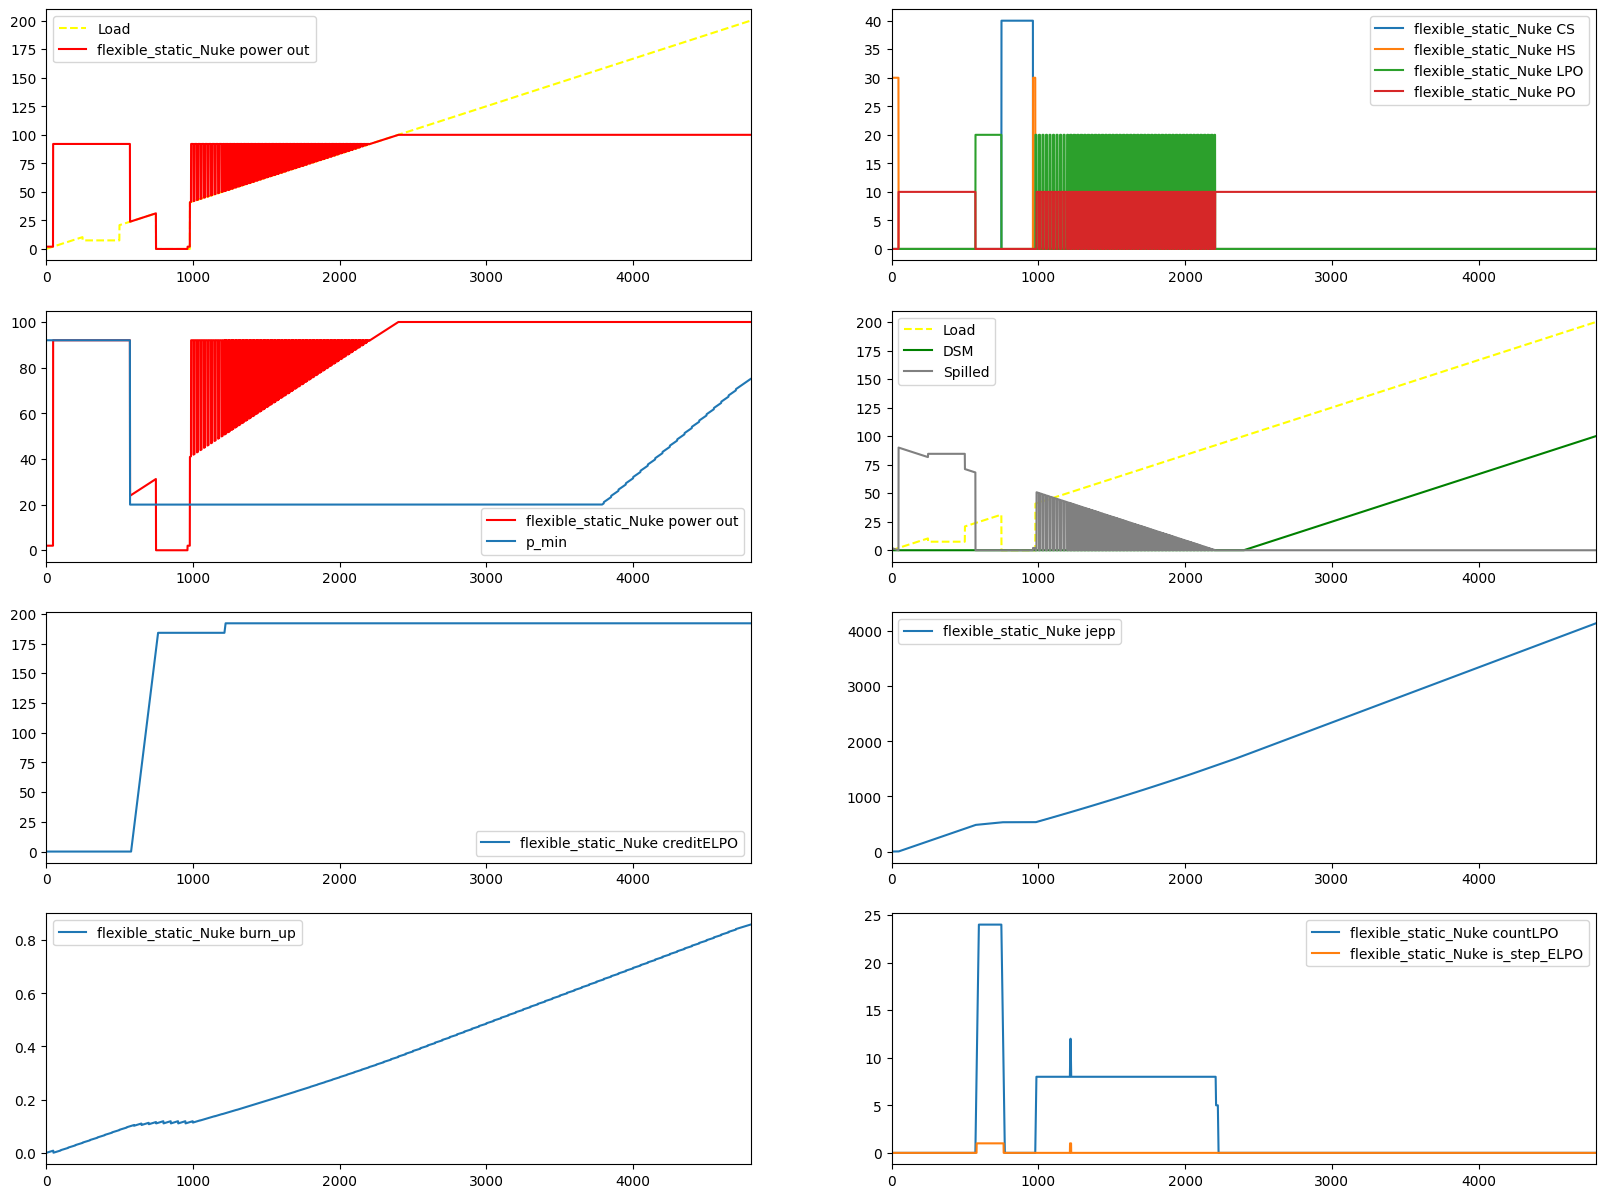

In [40]:
x_lb = 0
x_ub = global_step_count

if True:
    plt.figure(figsize=(20,15))
    ################################################################################################
    plt.subplot(421)
    plt.xlim(x_lb, x_ub)

    plt.plot(results["load"]["power_in"], label = "Load", linestyle = "dashed", color="yellow")

    if global_bool_Nuke_indiv:
        plt.plot(results["flexible_static_Nuke"]["electricity"], label = "flexible_static_Nuke power out", color="r")
    # end if

    if global_bool_Nuke_cluster:
        plt.plot(results["cluster_Nuke"]["power_out"], label = "Cluster_Nuke power out", color="orange")
    # end if

    if global_bool_CCGT_cluster:
        plt.plot(results["cluster_CCGT"]["power_out"], label = "Cluster_CCGT power out", color="b")
    # end if

    plt.legend()
    ################################################################################################
    plt.subplot(422)
    plt.xlim(x_lb, x_ub)

    if global_bool_Nuke_indiv:
        #plt.plot(results["flexible_static_Nuke"]["boolstate"], label = "flexible_static_Nuke state")
        plt.plot(40*results["flexible_static_Nuke"]["CS"], label = "flexible_static_Nuke CS")
        plt.plot(30*results["flexible_static_Nuke"]["HS"], label = "flexible_static_Nuke HS")
        plt.plot(20*results["flexible_static_Nuke"]["LPO"], label = "flexible_static_Nuke LPO")
        plt.plot(10*results["flexible_static_Nuke"]["PO"], label = "flexible_static_Nuke PO")
    # end if

    if global_bool_Nuke_cluster:
        plt.plot(results["cluster_Nuke"]["n_machine"], label = "Cluster_Nuke running machines")
    # end if

    if global_bool_CCGT_cluster:
        plt.plot(results["cluster_CCGT"]["n_machine"], label = "Cluster_CCGT running machines")
    # end if

    plt.legend()
    ################################################################################################
    plt.subplot(423)
    plt.xlim(x_lb, x_ub)

    if global_bool_Nuke_indiv:
        plt.plot(results["flexible_static_Nuke"]["electricity"], label = "flexible_static_Nuke power out", color="r")
        plt.plot(ratio_p_min, label = "p_min")
    # end if

    plt.legend()
    ################################################################################################
    plt.subplot(424)
    plt.xlim(x_lb, x_ub)

    plt.plot(results["load"]["power_in"], label = "Load", linestyle = "dashed", color="yellow")

    if global_bool_virtual_balancing:
        plt.plot(results["Demand_side_Management"]["power_out"], label = "DSM", color="g")
        plt.plot(results["spilled_energy"]["power_in"], label = "Spilled", color="grey")
    # end if

    plt.legend()
    ################################################################################################
    plt.subplot(425)
    plt.xlim(x_lb, x_ub)

    if global_bool_Nuke_indiv and global_NPP_bool_creditFPPI:
        plt.plot(results["flexible_static_Nuke"]["creditELPO"], label = "flexible_static_Nuke creditELPO")
    # end if

    plt.legend()
    ################################################################################################
    plt.subplot(426)
    plt.xlim(x_lb, x_ub)

    if global_bool_Nuke_indiv and global_NPP_bool_jepp:
        plt.plot(results["flexible_static_Nuke"]["jepp"], label = "flexible_static_Nuke jepp")
    # end if

    plt.legend()
    ################################################################################################
    plt.subplot(427)
    plt.xlim(x_lb, x_ub)

    if global_bool_Nuke_indiv and global_NPP_bool_jepp:
        plt.plot(results["flexible_static_Nuke"]["burn_up"], label = "flexible_static_Nuke burn_up")
    # end if

    plt.legend()
    ################################################################################################
    plt.subplot(428)
    plt.xlim(x_lb, x_ub)

    if global_bool_Nuke_indiv and global_NPP_bool_creditFPPI:
        plt.plot(results["flexible_static_Nuke"]["countLPO"], label = "flexible_static_Nuke countLPO")
        plt.plot(results["flexible_static_Nuke"]["is_step_ELPO"], label = "flexible_static_Nuke is_step_ELPO")
    # end if
    
    plt.legend()
    ################################################################################################
    plt.show()
# end if True to be able to collapse the displaying code

## Graphes individualisés pour export

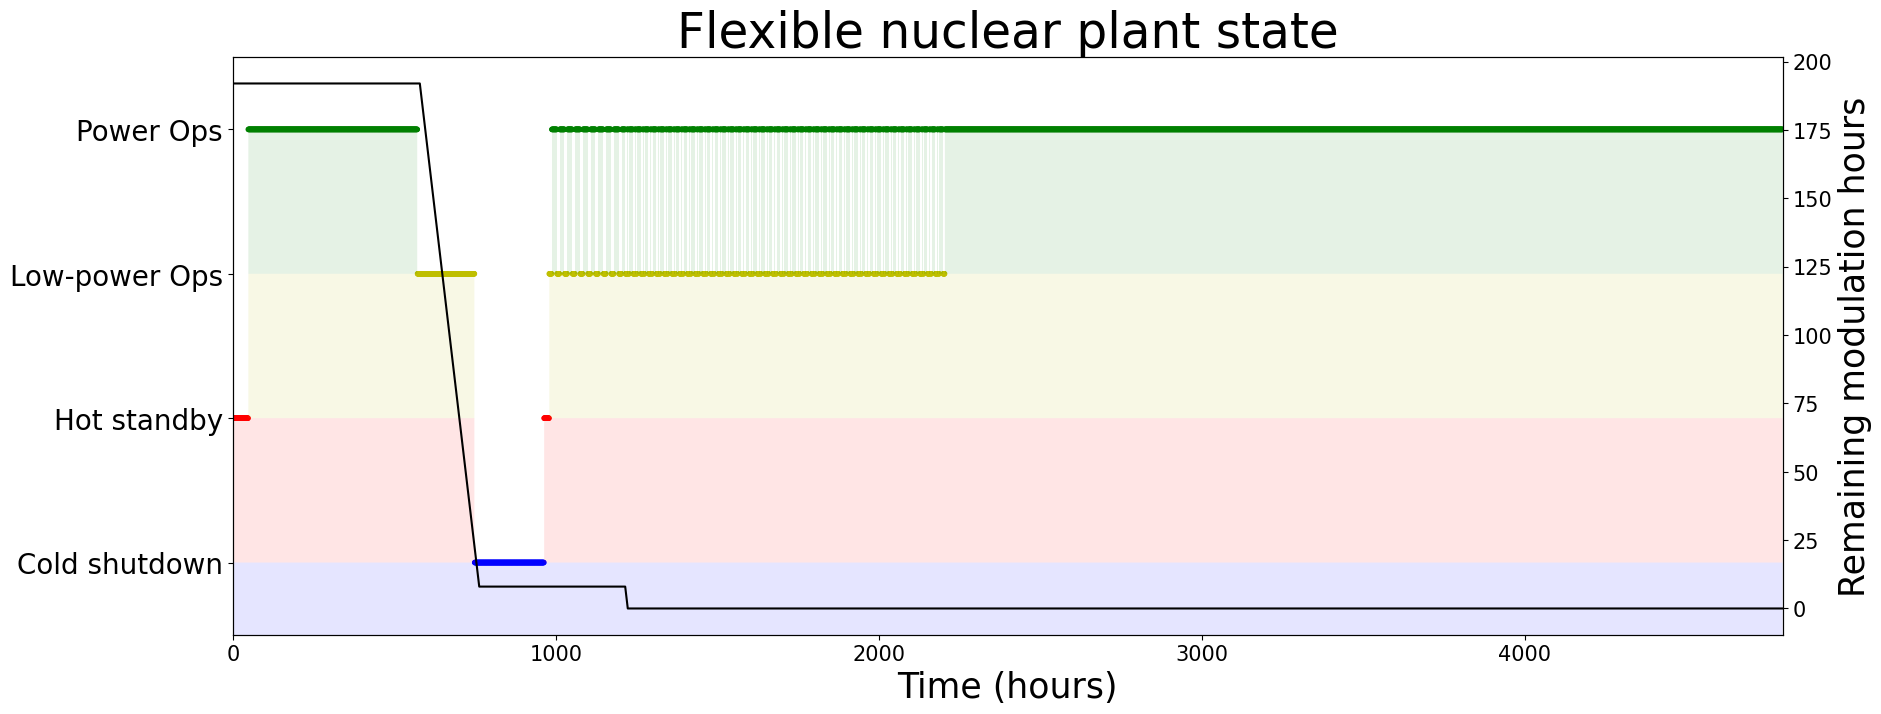

In [200]:
import matplotlib.colors as mcolors

#f = plt.figure(figsize=(20,7.5))
#ax = f.add_subplot(111)

graph_selector = 2

if graph_selector != 9:
    f, ax = plt.subplots(figsize=(20,7.5))
    ax.tick_params(axis='both', which='major', labelsize=15)
elif graph_selector ==9:
    f, (ax1, ax2) = plt.subplots(2,1,sharex=True, figsize=(20,15))
    ax1.tick_params(axis='both', which='major', labelsize=15)
    ax2.tick_params(axis='both', which='major', labelsize=15)

time = range(global_step_count)

plt.xlim(x_lb, x_ub)
plt.xlabel("Time (hours)", size=25)

if graph_selector not in [2,9]:
    plt.ylabel("Test just to set size", size=25)
#end if

if True:
    if graph_selector == 1:
        Title = "Nuclear production profile and load"
        plt.ylabel("Power (MW)")

        ax.plot(results["load"]["power_in"], label = "load", linestyle = "dashed", color="yellow")

        if global_bool_Nuke_indiv:
            ax.plot(results["flexible_static_Nuke"]["electricity"], label = "flexible_static_Nuke power out", color="r")
        # end if

        if global_bool_Nuke_cluster:
            ax.plot(results["cluster_Nuke"]["power_out"], label = "Cluster_Nuke power out", color="orange")
        # end if

        if global_bool_CCGT_cluster:
            ax.plot(results["cluster_CCGT"]["power_out"], label = "Cluster_CCGT power out", color="b")
        # end if
    ################################################################################################
    elif graph_selector == 2:
        Title = "Flexible nuclear plant state"
        #plt.ylabel("State")
        plt.ylim(5, 45)
        labels = ["Cold shutdown", "Hot standby", "Low-power Ops", "Power Ops"]
        colors = ["b", "r", "y", "g"]

        axbis = ax.twinx()
        axbis.set_ylabel("Remaining modulation hours", fontsize=25)
        axbis.tick_params(axis="y", labelsize=15)

        ax.set_yticks([10,20,30,40], labels)
        ax.tick_params(axis="y", labelsize=20)


        if global_bool_Nuke_indiv:

            def creditELPO(t):
                """Converts ELPO credit results into a function to be able to draw it onto a secondary yaxis"""
                return NPP_creditELPOmax - results["flexible_static_Nuke"]["creditELPO"][t]

            #ax.plot(results["flexible_static_Nuke"]["boolstate"], label = "flexible_static_Nuke state")
            #ax.plot(40*results["flexible_static_Nuke"]["CS"], label = "flexible_static_Nuke CS")
            #ax.plot(30*results["flexible_static_Nuke"]["HS"], label = "flexible_static_Nuke HS")
            #ax.plot(20*results["flexible_static_Nuke"]["LPO"], label = "flexible_static_Nuke LPO")
            #ax.plot(10*results["flexible_static_Nuke"]["PO"], label = "flexible_static_Nuke PO")

            state = 10*results["flexible_static_Nuke"]["CS"] + 20*results["flexible_static_Nuke"]["HS"] + 30*results["flexible_static_Nuke"]["LPO"] + 40*results["flexible_static_Nuke"]["PO"]

            # Setting colors for better understanding of states
            statec = []
            for t in range(len(state)):
                statec.append(colors[int(state[t]//10)-1])

            ax.scatter(x = time, y=state, c=statec, marker=".", label = "flexible_static_Nuke state")

            axbis.plot(NPP_creditELPOmax - results["flexible_static_Nuke"]["creditELPO"], color = "black", label = "flexible_static_Nuke creditELPO")

            ax.fill_between(time, 10, 0, where=(state>=10), facecolor="b", alpha=.1)
            ax.fill_between(time, 20, 10, where=(state>=20), facecolor="r", alpha=.1)
            ax.fill_between(time, 30, 20, where=(state>=30), facecolor="y", alpha=.1)
            ax.fill_between(time, 40, 30, where=(state>=40), facecolor="g", alpha=.1)
        # end if

        if global_bool_Nuke_cluster:
            ax.plot(results["cluster_Nuke"]["n_machine"], label = "Cluster_Nuke running machines")
        # end if

        if global_bool_CCGT_cluster:
            ax.plot(results["cluster_CCGT"]["n_machine"], label = "Cluster_CCGT running machines")
        # end if
    ################################################################################################
    elif graph_selector == 3:
        Title = "Nuclear production level and minimum level jig"
        plt.ylabel("Power (MW)")

        if global_bool_Nuke_indiv:
            ax.plot(results["flexible_static_Nuke"]["electricity"], label = "flexible_static_Nuke power out", color="r")
            ax.plot(ratio_p_min, label = "p_min")

            ax.fill_between(time, ratio_p_min, 0, color = "b", alpha=.1)

        plt.legend(loc="center", fontsize=15)
        # end if
    ################################################################################################
    elif graph_selector == 4:
        Title = "Balancing load: unsupplied and spilled energy"
        plt.ylabel("Power (MW)")

        ax.plot(results["load"]["power_in"], label = "Load", linestyle = "dashed", color="yellow")

        if global_bool_virtual_balancing:
            ax.plot(results["Demand_side_Management"]["power_out"], label = "DSM", color="r")
            ax.plot(results["spilled_energy"]["power_in"], label = "Spilled", color="b")

            ax.fill_between(time, results["Demand_side_Management"]["power_out"], 0, color = "r", alpha=.5)
            ax.fill_between(time, results["spilled_energy"]["power_in"], 0, color = "b", alpha=.5)
        # end if
    ################################################################################################
    elif graph_selector == 5:
        Title = "Ability to modulate power"
        plt.ylabel("Remaining modulation hours")

        if global_bool_Nuke_indiv and global_NPP_bool_creditFPPI:
            ax.plot(NPP_creditELPOmax - results["flexible_static_Nuke"]["creditELPO"], label = "flexible_static_Nuke creditELPO")

            ax.fill_between(time, NPP_creditELPOmax - results["flexible_static_Nuke"]["creditELPO"], 0, alpha=.5)

        # end if
    ################################################################################################
    elif graph_selector == 6:
        Title = "Full power days monitoring"
        plt.ylabel("Full power days")

        if global_bool_Nuke_indiv and global_NPP_bool_jepp:
            ax.plot(results["flexible_static_Nuke"]["jepp"], label = "flexible_static_Nuke jepp")
        # end if
    ################################################################################################
    elif graph_selector == 7:
        Title = "Evolution of the burn-up during the campaign"
        plt.ylabel("Burn-up")

        if global_bool_Nuke_indiv and global_NPP_bool_jepp:
            ax.plot(results["flexible_static_Nuke"]["burn_up"], label = "flexible_static_Nuke burn_up")
        # end if
    ################################################################################################
    elif graph_selector == 8:
        Title = "Extended low-power operations monitoring"
        plt.ylabel("LPO counter on past 24 hours")

        if global_bool_Nuke_indiv and global_NPP_bool_creditFPPI:
            net_ELPO_signal = results["flexible_static_Nuke"]["countLPO"] * results["flexible_static_Nuke"]["is_step_ELPO"]

            ax.plot(results["flexible_static_Nuke"]["countLPO"], label = "LPO counter on past 24 hours")
            #ax.plot(results["flexible_static_Nuke"]["is_step_ELPO"], label = "flexible_static_Nuke is_step_ELPO")
            ax.plot(net_ELPO_signal, label = "ELPO filling")

            ax.fill_between(time, net_ELPO_signal, 0, color="orange", alpha=.5)
        # end if
    ################################################################################################
    elif graph_selector == 9:
        Title = "Burn-up approximation assessment"

        if global_bool_Nuke_indiv and global_NPP_bool_jepp:
            ax1.set_title(Title, fontsize=35)
            ax1.set_ylabel("Burn-up approximation", size=25)
            ax1.plot(results["flexible_static_Nuke"]["burn_up"], label = "flexible_static_Nuke burn_up")
            ax1.legend(fontsize=15)

            ax2.set_ylabel("Full power days", size=25)
            ax2.plot(results["flexible_static_Nuke"]["jepp"], label = "flexible_static_Nuke jepp")
            ax2.legend(fontsize=15)
        # end if

# end if True to be able to collapse the displaying code

if graph_selector not in [9]:
    plt.title(Title, size=35)
#end if

if graph_selector not in [2,3,8,9]:
    plt.legend(fontsize=15)
#end if
Figure_title = "1REP-"+str(graph_selector)+".png"
plt.savefig(fname=Figure_title)    
plt.show()

## Questions et sujets en cours